# Software Setup, Dependencies

In [1]:
%pip install -r requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import importlib

import salduba.simulation.ggk as ggk
importlib.reload(ggk)
from salduba.simulation.ggk import exponential, parametrized_gamma


In [15]:

probs = np.random.binomial(1, 0.0, 100)

probs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Set up simulation parameters

In [3]:
inter_arrival_time = 1.0
op_time = inter_arrival_time/1000
target_utilization = 0.8
k_servers: int = 10
processing_time = inter_arrival_time * k_servers * target_utilization
gamma_shape = 9.0

n_jobs: int = 10000
sampling_target: float = 5.0
simulation_factor: float = 100.0

sampling_period = int(inter_arrival_time * sampling_target)
time_limit = int(inter_arrival_time * n_jobs + target_utilization/(1-target_utilization)*inter_arrival_time*simulation_factor)
jobs_limit: int = round(time_limit/inter_arrival_time)

time_unit: float = sampling_period*10

arrival_distribution = exponential(inter_arrival_time, time_unit)
processing_distribution = parametrized_gamma(gamma_shape, processing_time, time_unit)


# Simulation Values

## Arrival Times & Jobs Data Frame

*jobs := [arrival time, processing time, start, complete, arrived, pending]*

- **Id** A unique Id for the job, corresponding to its arrival order
- **Arrival Time**: When the job arrives to the system
- **Processing Time**: The time the system takes to process the job once started
- **Start**: The time when the system starts processing the job.
- **Complete**: The time when the system completes processing of the job. It is always the case that $Complete = ArrivalTime + ProcessingTime$
- **Arrived**: How many jobs have arrived up until the time of this arrival, including this one.
- **Pending**: How many jobs are in the system or "pending" at the time of arrival.
- **WIP**: How many jobs are currently being actively worked on.
- **DONE**: How many jobs are currently Complete.

In [6]:
jobs = ggk.initialize_jobs(n_jobs, arrival_distribution, processing_distribution)


## Fill-In Dynamic values:

- Start
- Complete
- Arrived
- Pending
- WIP
- DONE


In [7]:

ggk.fill_in_dynamic_values(jobs, k_servers)

,Id,Arrival,Processing,Start,Complete,Arrived,Pending,WIP,DONE
0,0,0,527,1,528,1,0,0,0
1,1,42,432,43,475,2,1,1,0
2,2,89,483,90,573,3,2,2,0
3,3,150,573,151,724,4,3,3,0
4,4,176,433,177,610,5,4,4,0
...,...,...,...,...,...,...,...,...,...
9995,9995,492346,371,492347,492718,9996,6,6,9989
9996,9996,492355,289,492356,492645,9997,7,7,9989
9997,9997,492428,605,492429,493034,9998,6,6,9991
9998,9998,492446,589,492447,493036,9999,7,7,9991


# Create the Event Logs

- Arrivals: Arrival events
- Starts: Start Events
- Completes: Complete Events.

In [9]:
logs = ggk.event_logs(jobs)


{'arrivals':         Id  Timestamp    Event
 0        0          0  ARRIVAL
 1        1         42  ARRIVAL
 2        2         89  ARRIVAL
 3        3        150  ARRIVAL
 4        4        176  ARRIVAL
 ...    ...        ...      ...
 9995  9995     492346  ARRIVAL
 9996  9996     492355  ARRIVAL
 9997  9997     492428  ARRIVAL
 9998  9998     492446  ARRIVAL
 9999  9999     492545  ARRIVAL
 
 [10000 rows x 3 columns],
 'starts':         Id  Timestamp  Event
 0        0          1  START
 1        1         43  START
 2        2         90  START
 3        3        151  START
 4        4        177  START
 ...    ...        ...    ...
 9995  9995     492347  START
 9996  9996     492356  START
 9997  9997     492429  START
 9998  9998     492447  START
 9999  9999     492546  START
 
 [10000 rows x 3 columns],
 'completes':         Id  Timestamp     Event
 0        0        528  COMPLETE
 1        1        475  COMPLETE
 2        2        573  COMPLETE
 3        3        724  COMPLET

## With Some derived statistics for control

- Busy Time: Should be equivalent to Processing Times
- Lead Time: Total Wait + Processing time
- Wait Time: Time waiting for a processor (+1 as artificially introduced scheduling delay)
- Total Time to complete simulation and the equivalent utilization. Note that this needs to be improved by removing ramp-up and ramp-down times.

In [59]:
busy_time = completes['Timestamp'] - starts['Timestamp']
(busy_time.mean(), busy_time.std())

(398.7872, 130.3154454686503)

In [60]:
lead_time = completes['Timestamp'] - arrivals['Timestamp']
(lead_time.mean(), lead_time.std())

(455.4562, 158.6210904848238)

In [61]:
wait_time = starts['Timestamp'] - arrivals['Timestamp']
(wait_time.mean(), wait_time.std())

(56.669, 91.22930185829416)

In [62]:
total_time = max(completes['Timestamp'])

utilization = sum(busy_time)/(total_time*k_servers)

(total_time, utilization)

(498175, 0.8004962111707733)

In [63]:
time_bins = [idx*sampling_target for idx in range(0, round(total_time/sampling_target)+2)]

arrival_counts = pd.DataFrame(arrivals.groupby(pd.cut(arrivals['Timestamp'], time_bins), observed=True).size(), columns=['count'])
completion_counts = pd.DataFrame(completes.groupby(pd.cut(completes['Timestamp'], time_bins), observed=True).size(), columns=['count'])
start_counts =  pd.DataFrame(starts.groupby(pd.cut(starts['Timestamp'], time_bins), observed=True).size(), columns=['count'])


In [64]:
events['wip_change'] = events['Event'].apply(lambda ev: 1 if ev == 'ARRIVAL' else -1 if ev == 'COMPLETE' else 0)
events['busy_change'] = events['Event'].apply(lambda ev: 1 if ev == 'START' else -1 if ev == 'COMPLETE' else 0)
events['wip'] = events['wip_change'].cumsum()
events['busy'] = events['busy_change'].cumsum()

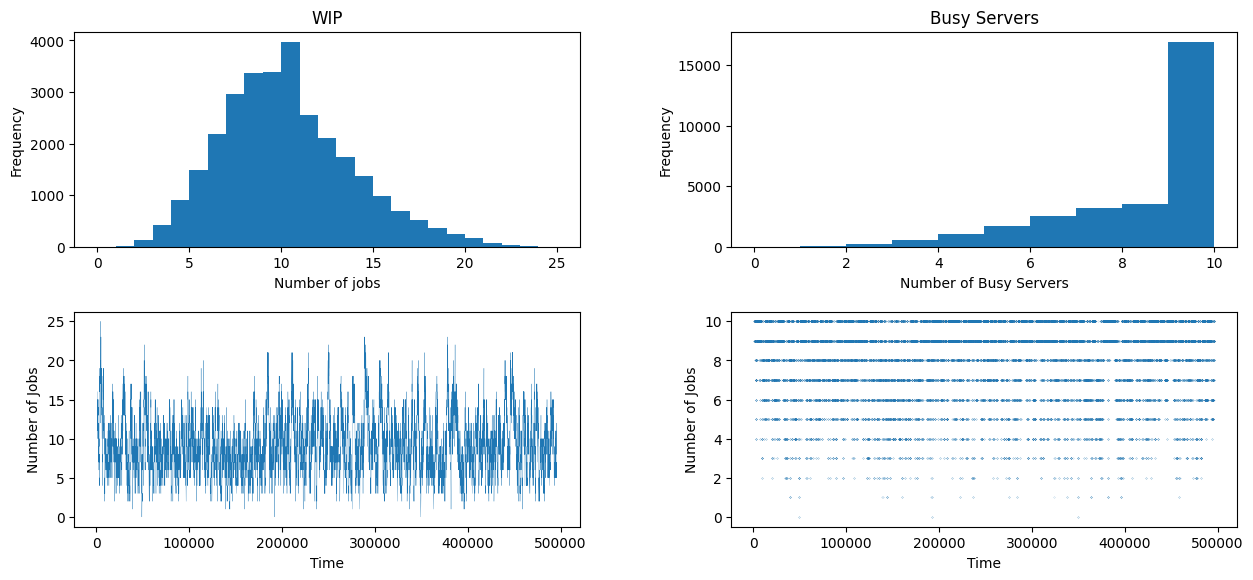

In [65]:
subset = events[100:-100]
markersize = 0.1
linewidth = 0.2
bins = 25

fig, ((tl, tr), (bl, br)) = plot.subplots(nrows=2, ncols=2, figsize=(15, 5))
plot.subplots_adjust(top = 1.0, bottom=0.01, hspace=0.3, wspace=0.3)


#customer_counts.plot.bar(title="Unique Active Customers", ax = axes[0][0])

#events[['Timestamp', 'wip', 'busy']].plot.bar(x='Timestamp')
tl.hist(subset['wip'], bins=bins)
tl.set_xlabel("Number of jobs")
tl.set_ylabel("Frequency")
bl.plot(subset['Timestamp'], subset['wip'], markersize=markersize, linewidth=linewidth)
bl.set_xlabel("Time")
bl.set_ylabel("Number of Jobs")
tl.set_title("WIP")
tr.hist(subset['busy'], bins=k_servers)
tr.set_title("Busy Servers")
tr.set_xlabel("Number of Busy Servers")
tr.set_ylabel("Frequency")
br.plot(subset['Timestamp'], subset['busy'], 'o', markersize=markersize, linewidth=linewidth)
br.set_xlabel("Time")
br.set_ylabel("Number of Jobs")


plot.show()



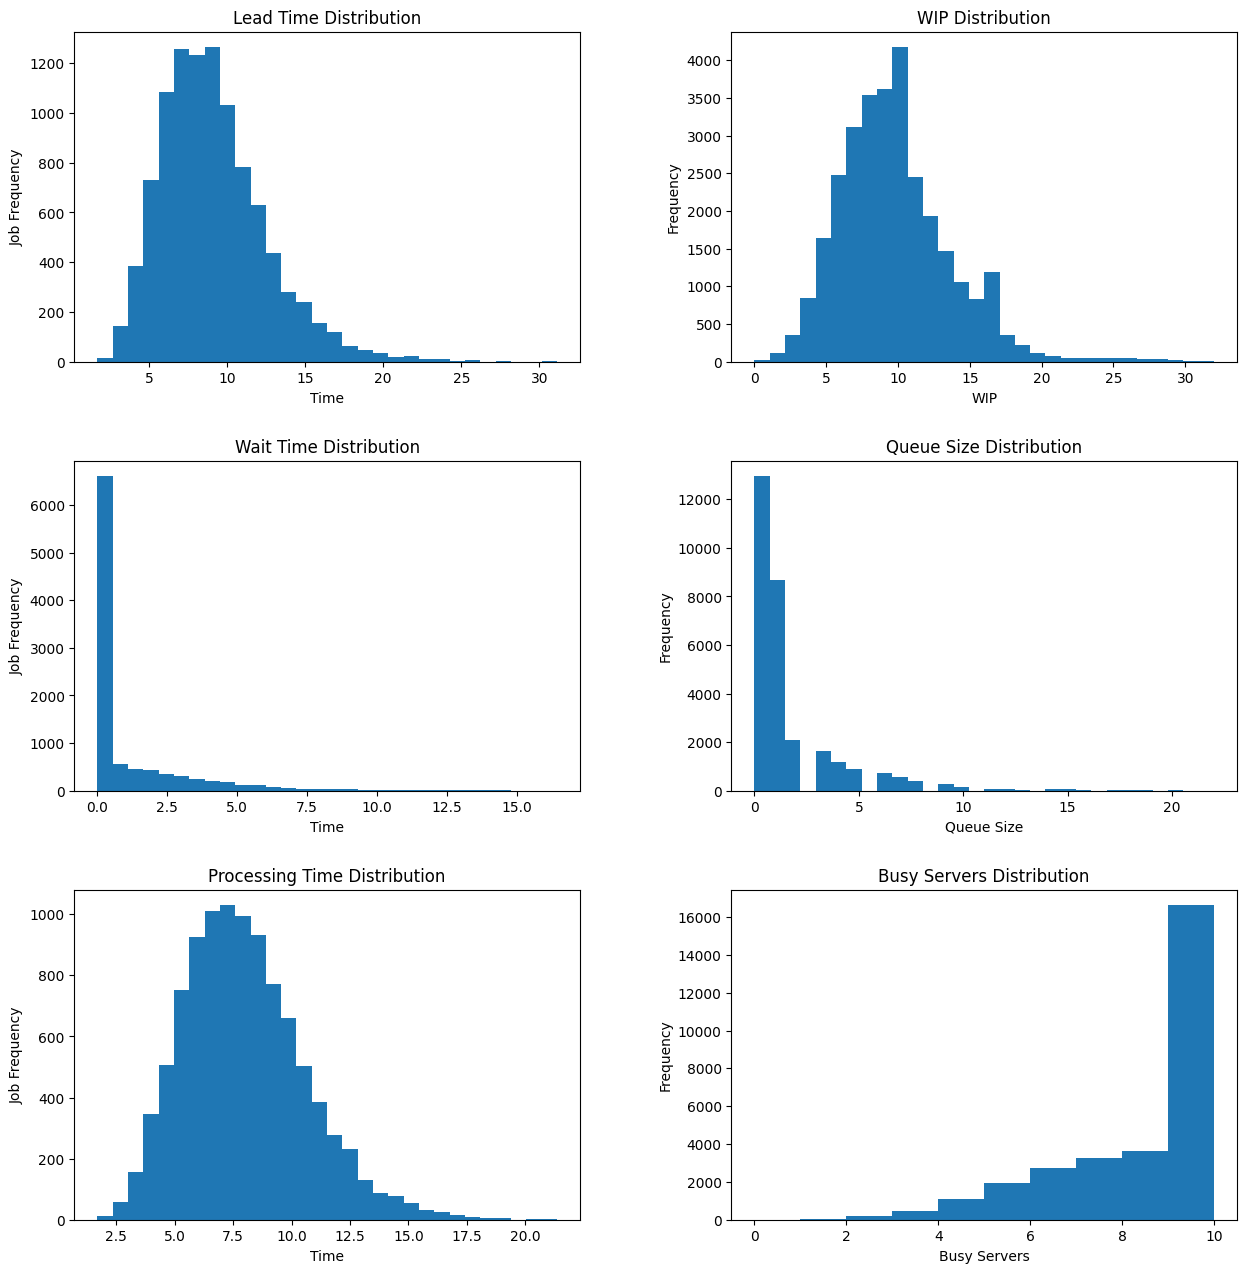

In [22]:
subset = events
markersize = 0.1
linewidth = 0.2
bins = 30

fig, ((tl, tr), (ml, mr), (bl, br)) = plot.subplots(nrows=3, ncols=2, figsize=(15, 12))
plot.subplots_adjust(top = 1.0, bottom=0.01, hspace=0.3, wspace=0.3)

tl.hist(lead_time, bins=bins)
tl.set_title('Lead Time Distribution')
tl.set_xlabel('Time')
tl.set_ylabel('Job Frequency')

tr.hist(subset['wip'], bins=bins)
tr.set_title('WIP Distribution')
tr.set_xlabel('WIP')
tr.set_ylabel('Frequency')

ml.hist(wait_time, bins=bins)
ml.set_title('Wait Time Distribution')
ml.set_xlabel('Time')
ml.set_ylabel('Job Frequency')

mr.hist(subset['wip']-subset['busy'], bins=bins)
mr.set_title('Queue Size Distribution')
mr.set_xlabel('Queue Size')
mr.set_ylabel('Frequency')

bl.hist(busy_time, bins=bins)
bl.set_title('Processing Time Distribution')
bl.set_xlabel('Time')
bl.set_ylabel('Job Frequency')

br.hist(subset['busy'], bins=k_servers)
br.set_title('Busy Servers Distribution')
br.set_xlabel('Busy Servers')
br.set_ylabel('Frequency')


plot.show()


In [15]:
events

,Id,Timestamp,Event,wip_change,busy_change,wip,busy
0,0,0.000000,ARRIVAL,1,0,1,0
1,0,0.001000,START,0,1,1,1
2,1,0.143954,ARRIVAL,1,0,2,1
3,1,0.144954,START,0,1,2,2
4,2,3.260838,ARRIVAL,1,0,3,2
...,...,...,...,...,...,...,...
29995,9995,9950.312004,COMPLETE,-1,-1,4,4
29996,9992,9950.937170,COMPLETE,-1,-1,3,3
29997,9997,9952.446144,COMPLETE,-1,-1,2,2
29998,9998,9953.826383,COMPLETE,-1,-1,1,1


Text(0, 0.5, 'Count per ~10 time units')

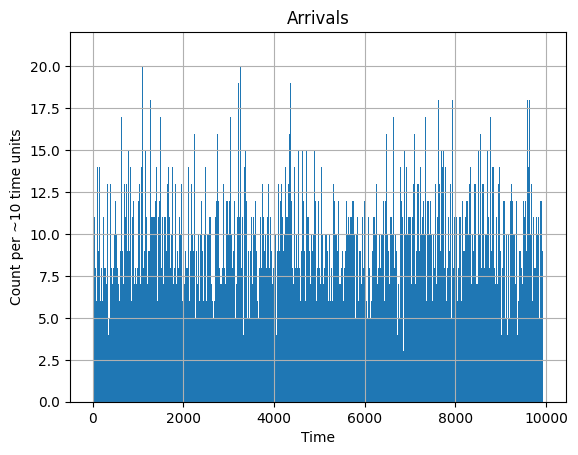

In [16]:
bins = 1000
arrivals.hist('Timestamp', bins=bins)
plot.title("Arrivals")
plot.xlabel("Time")
plot.ylabel(f"Count per ~{round(total_time/bins)} time units")
